# **Anomaly Detection using MISC-OD**

The `MISC-OD` (Mutual Information and Reduced Spectral Clustering - Outlier Detection) algorithm was evaluated in comparison to the Local Outlier Factor (LOF) and Isolation Forest methods for novelty detection using a version of the `Wisconsin Breast Cancer (Diagnostics) dataset`.

For detailed insights into this methodology, please refer to the following reference: [*A Novel Unsupervised Outlier Detection Algorithm Based on Mutual Information and Reduced Spectral Clustering*](https://www.mdpi.com/2079-9292/12/23)

---


## Results

MISC-OD had a high ROC comparable to Isolation Forest, albeit slightly lower. Despite this, its AUPRC and Average Precision were higher. LOF had higher AUPRC and AP to MISC-OD but had a lower ROC. In conclusion, each model demonstrated merits depending on the evaluation metric.


| Model    | ROC   | AUPRC   | AP    |
|----------|-------|-------|-------|
| MISC-OD  | 0.956 | 0.811 | 0.713 |
| LOF      | 0.901 | 0.857 | 0.735 |
| IsoForest| 0.967 | 0.670 | 0.681 |


# Execution

## Libraries

In [14]:
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import warnings

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import roc_curve, auc, average_precision_score, precision_recall_curve
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

## Data Loading and Preprocessing

The original Wisconsin-Breast Cancer (Diagnostics) dataset (WBC) from UCI machine learning repository is a classification dataset, which records the measurements for breast cancer cases. There are two classes, benign and malignant. The malignant class of this dataset is downsampled to 21 points, which are considered as outliers, while points in the benign class are considered inliers.

---

Data retrieved from: <br>
[Stony Brook University ODDS Library: Breast Cancer Wisconsin (Original) Dataset](https://odds.cs.stonybrook.edu/wbc/) (Accessed May 14, 2024)

In [15]:
cols = ['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1',
        'compactness1', 'concavity1', 'concave_points1', 'symmetry1',
        'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2',
        'smoothness2', 'compactness2', 'concavity2', 'concave_points2',
        'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3',
        'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3',
        'symmetry3', 'fractal_dimension3']

mat_data = scipy.io.loadmat('wbc.mat')
X = mat_data['X']
y = mat_data['y'].reshape(-1)

df_features = pd.DataFrame(data=X, columns=cols)
df_features.head(3)

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,0.310426,0.157254,0.301776,0.179343,0.407692,0.189896,0.156139,0.237624,0.416667,0.162174,...,0.255425,0.192964,0.245480,0.129276,0.480948,0.145540,0.190895,0.442612,0.278336,0.115112
1,0.288655,0.202908,0.289130,0.159703,0.495351,0.330102,0.107029,0.154573,0.458081,0.382266,...,0.233725,0.225746,0.227501,0.109443,0.396421,0.242852,0.150958,0.250275,0.319141,0.175718
2,0.119409,0.092323,0.114367,0.055313,0.449309,0.139685,0.069260,0.103181,0.381313,0.402064,...,0.081821,0.097015,0.073310,0.031877,0.404345,0.084903,0.070823,0.213986,0.174453,0.148826


In [16]:
df_features.describe()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
count,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,...,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000
mean,0.255100,0.286028,0.248241,0.144444,0.367621,0.200831,0.125377,0.146490,0.352271,0.276147,...,0.207091,0.318102,0.195870,0.102009,0.365690,0.165125,0.148847,0.279099,0.232921,0.168817
std,0.100344,0.143315,0.099615,0.075817,0.125914,0.124455,0.131000,0.117235,0.129816,0.144080,...,0.097739,0.156072,0.096841,0.069345,0.140127,0.115264,0.134176,0.159570,0.093873,0.105667
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.039806,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000197,0.001115
25%,0.196957,0.185238,0.190243,0.100870,0.279904,0.115085,0.049783,0.077411,0.267298,0.181971,...,0.153771,0.203292,0.143272,0.066942,0.266493,0.086358,0.064065,0.185601,0.171151,0.099403
50%,0.251029,0.264964,0.241103,0.136055,0.358626,0.175541,0.091061,0.120204,0.334596,0.246630,...,0.197439,0.293310,0.184173,0.090309,0.365053,0.143406,0.118291,0.270893,0.224522,0.148006
75%,0.311136,0.354329,0.301119,0.178865,0.446601,0.258788,0.155746,0.176615,0.430051,0.337984,...,0.250800,0.401652,0.236416,0.123661,0.449581,0.211830,0.193990,0.349485,0.289227,0.212613
max,0.768091,1.000000,0.758137,0.647508,1.000000,0.792037,0.999063,0.906064,0.850000,0.964406,...,0.821060,0.875533,0.778873,0.678038,0.854718,1.000000,1.000000,1.000000,0.622708,1.000000


## Data Preprocessing

In [17]:
scaler = StandardScaler()
inliers = X[y == 0]
inliers = scaler.fit_transform(inliers)
X = scaler.transform(X)

## Baselines

### LOF

In [18]:
baseline_data = []

best_score = 0
for n in range(2, 30):
    lof = LocalOutlierFactor(n_neighbors=n, novelty=True)
    lof.fit(inliers)
    scores = lof.predict(X)

    fpr, tpr, thresholds = roc_curve(y, -scores)
    roc_auc = auc(fpr, tpr)

    pr, rc, thr = precision_recall_curve(y, -scores)
    auprc = auc(rc, pr)

    ap = average_precision_score(y, -scores)

    if roc_auc > best_score:
        best_score = roc_auc
        res = {'Model': 'LOF',
               'roc': roc_auc,
               'auprc': auprc,
               'ap': ap}

baseline_data.append(res)
print(res)

{'Model': 'LOF', 'roc': 0.9019607843137255, 'auprc': 0.8574213311055416, 'ap': 0.7348927875243665}


### Isolation Forest

In [19]:

isolationforest = IsolationForest(random_state=42)
isolationforest.fit(inliers)
scores = isolationforest.score_samples(X)

fpr, tpr, thresholds = roc_curve(y, -scores)
roc_auc = auc(fpr, tpr)
pr, rc, thr = precision_recall_curve(y, -scores)
auprc = auc(rc, pr)
ap = average_precision_score(y, -scores)

res = {'Model': 'IsoForest',
       'roc': roc_auc,
       'auprc': auprc,
       'ap': ap}

baseline_data.append(res)
print(res)

{'Model': 'IsoForest', 'roc': 0.9666533279978657, 'auprc': 0.6703144870482183, 'ap': 0.6805501260777997}


## MISC-OD

### Initial Demonstration

In [20]:
def mutual_information_matrix(X):
    W = np.zeros((X.shape[1], X.shape[1]))
    d = X.shape[1]

    for i in range(d):
        for j in range(i+1, d):
            W[i, j] = mutual_info_regression(
                X[:, i].reshape(-1, 1), X[:, j])[0]
            W[j, i] = W[i, j]
    return W


def k_smallest_eigenvectors(W, k):
    D = np.diag(np.sum(W, axis=1))
    L_unnormalized = D - W

    D_sqrt_inv = np.sqrt(np.linalg.inv(D))
    L_normalized = np.dot(np.dot(D_sqrt_inv, L_unnormalized), D_sqrt_inv)

    eigenvalues, eigenvectors = np.linalg.eig(L_normalized)
    idx = eigenvalues.argsort()[1:k+1]
    k_smallest_eigenvectors = eigenvectors[:, idx]

    return k_smallest_eigenvectors


mi_matrix = mutual_information_matrix(inliers)
k_EV = k_smallest_eigenvectors(mi_matrix, 2)

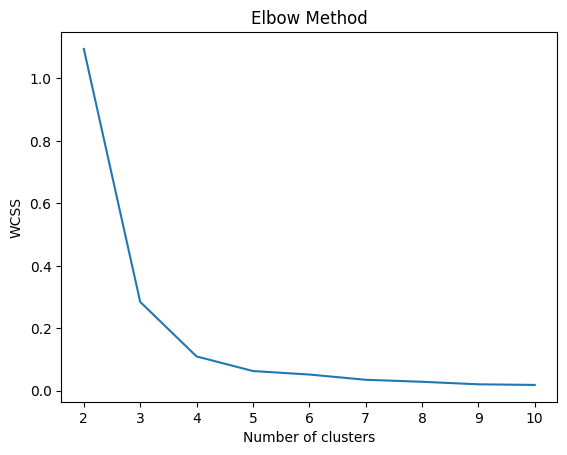

In [21]:
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans.fit(k_EV)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(2, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [22]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(k_EV)
cluster_labels = kmeans.labels_
clusters = {label: [i for i, l in enumerate(
    kmeans.labels_) if l == label] for label in set(kmeans.labels_)}

In [23]:
for k, v in clusters.items():
    print(f"Cluster {k}: {[cols[i] for i in v]}")

Cluster 0: ['smoothness1', 'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3']
Cluster 1: ['radius1', 'perimeter1', 'area1', 'radius3', 'perimeter3', 'area3']
Cluster 2: ['texture1', 'radius2', 'texture2', 'perimeter2', 'area2', 'texture3']


## Initial Scoring

In [24]:
o_scores = []
for _, i in clusters.items():
    data_subset = X[:, i]
    lof = LocalOutlierFactor(n_neighbors=30, novelty=True)
    lof.fit(inliers[:, i])
    scores = lof.predict(data_subset)
    o_scores.append(-scores)

aggregate_scores = np.sum(o_scores, axis=0)
fpr, tpr, thresholds = roc_curve(y, aggregate_scores)
roc_auc = auc(fpr, tpr)
roc_auc

0.846938775510204

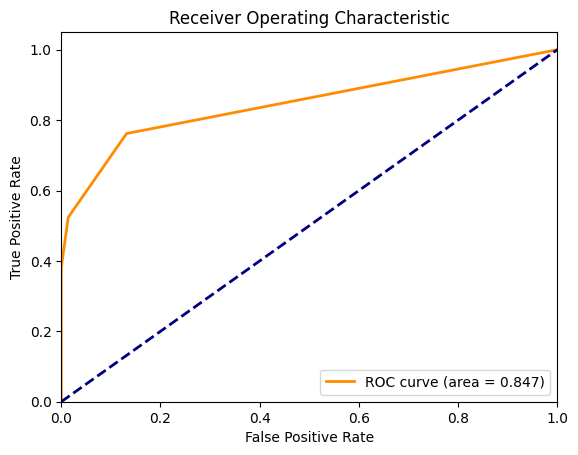

In [25]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Hyperparameter Tuning

In [26]:
def auto_MISC_OD(X,
                 y,
                 min_k_eigvec=1,
                 max_k_eigvec=5,
                 min_n_neighbors=20,
                 max_n_neighbors=25,
                 min_k_clusters=2,
                 max_k_clusters=5):

    inliers = X[y == 0]
    mi_matrix = mutual_information_matrix(inliers)
    best_score = 0

    for k_eigvecs in range(min_k_eigvec, max_k_eigvec+1):
        k_EV = k_smallest_eigenvectors(mi_matrix, k_eigvecs)
        
        for k_clusters in range(min_k_clusters, max_k_clusters+1):
            kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(k_EV)
            cluster_labels = kmeans.labels_
            clusters = {label: [i for i, l in enumerate(
                kmeans.labels_) if l == label] for label in set(kmeans.labels_)}
        
            for n in range(min_n_neighbors, max_n_neighbors+1):
                o_scores = []
                for _, i in clusters.items():
                    data_subset = X[:, i]
                    lof = LocalOutlierFactor(n_neighbors=n, novelty=True)
                    lof.fit(inliers[:, i])
                    scores = lof.predict(data_subset)
                    o_scores.append(-scores)

                aggregate_scores = np.sum(o_scores, axis=0)
                fpr, tpr, thresholds = roc_curve(y, aggregate_scores)
                roc_auc = auc(fpr, tpr)
                
                if roc_auc > best_score:
                    best_score = roc_auc
                    pr, rc, thr = precision_recall_curve(y, aggregate_scores)
                    auprc = auc(rc, pr)
                    res_dict = {
                        'Model': 'MISC-OD',
                        'roc': roc_auc,
                        'auprc': auprc,
                        'ap': average_precision_score(y, aggregate_scores)
                    }
    return res_dict

res = auto_MISC_OD(
    X,
    y,
    min_k_eigvec=1,
    max_k_eigvec=5,
    min_n_neighbors=10,
    max_n_neighbors=30,
    min_k_clusters=2,
    max_k_clusters=5
)

baseline_data.append(res)

## Final Result

In [28]:
display(pd.DataFrame(baseline_data))

,Model,roc,auprc,ap
0,LOF,0.901961,0.857421,0.734893
1,IsoForest,0.966653,0.670314,0.680550
2,MISC-OD,0.956182,0.810847,0.712963


## **Acknowledgements**

Huang, Y., Liu, W., Li, S., Guo, Y., & Chen, W. (2023). *A Novel Unsupervised Outlier Detection Algorithm Based on Mutual Information and Reduced Spectral Clustering*. *Electronics*, 12(23). MDPI AG. Available at [https://www.mdpi.com/2079-9292/12/23](https://www.mdpi.com/2079-9292/12/23) (accessed May 14, 2024).

Wolberg,William, Mangasarian,Olvi, Street,Nick, and Street,W.. (1995). Breast Cancer Wisconsin (Diagnostic). UCI Machine Learning Repository. https://doi.org/10.24432/C5DW2B.

---

*The original dataset was downloaded from Stony Brook University's ODDS library:* <br>
*Rayana, S. (2016). ODDS Library [http://odds.cs.stonybrook.edu]. Stony Brook, NY: Stony Brook University, Department of Computer Science.*
<br>

Data retrieved from: <br>
[Stony Brook University ODDS Library: Breast Cancer Wisconsin (Original) Dataset](https://odds.cs.stonybrook.edu/wbc/) (Accessed May 14, 2024)